# Advanced NLP

Earlier we saw a basic introduction to NLP where we used the Bag of Words approach to create models that classify text, whether by counting up the occurrences of each word or finding their relative frequency.

There are however more advanced methods we can apply to our text data to extract even more insights, which we will be covering in this workbook.

To access these materials you will need to ensure you have the following libraries installed:

In [1]:
import nltk
import spacy
import textblob
import wordcloud

In [5]:
print(wordcloud.__version__)

1.9.2


If any of these libraries do not work you will need to install them (you may need your organization's permission for this). To install a library:

<ol>
    <li> On the Jupyter Notebook navigator (where you opened this workbook) select <b>New</b> and then <b>Terminal</b></li>
    <li> Type in <i>pip install [name_of_library]</i></li>
    <li> For spacy, you will also need to run <i>python -m spacy download en_core_web_sm</i></li>
</ol>

You will also require the following functions from NLTK:

In [8]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Alastair
[nltk_data]     Tyson\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In this workbook we will cover several skills, including extra cleaning steps, sentiment analysis and special visualizations.

Let's begin!

# Stemming and Lemmatization

Earlier we used a Bag of Words approach to break down the words within a corpus into a series of vectors. Initially there was the issue of "my" and "My", the same word listed twice but recognised as two different entities- we solved this by telling Python to ignore capitals (although this can create issues in cases where one is a proper noun, and the other isn't- like China and china, they would be treated as the same). 

Another issue is words which are some variation of each other, such as "play", "playing", "played" and "plays" which would all be counted as their own item. Or words which are synonyms for each other like "happy", "glad" and "joyful". A model relying on a Bag of Words method may underfit if there are many words which are essentially the same as their power will be diluted. 

Stemming and lematization are techniques we can use to normalize our data to help us with our analysis.

## 1) Stemming

In this approach words are reduced to their stems, for example "playing", "played" and "plays" would all be reduced to "play". Computationally, this approach is very quick (as you are essentially cutting words down) but it may not be accurate as it can cut down words to something grammatically incorrect or completely change the meaning (i.e. "Playstation" -> "Play") .

There are two main methods for using stemming, <b>Porter Stemmer</b> and <b> Lancaster Stemmer</b>. 

Porter follows a set of rules for breaking down a word which you can read more about <a href='https://vijinimallawaarachchi.com/2017/05/09/porter-stemming-algorithm/'>here</a>. 

Lancaster is simpler and just cuts down a word based on known suffices, but can result in non-sensical or grammatically incorrect words.

Both Porter and Lancaster only work with English, for any other language (including English) you can use <b>Snowball</b>.

Let's do an example, for each we need to set up the stemmer as a function and then pass the word we want to stem through an attribute called `.stem()`.

Much of the work we will be doing here will come from the <b>NLTK</b> (Natural Language Toolkit) library.

In [9]:
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import SnowballStemmer

porter=PorterStemmer()
lancaster=LancasterStemmer()
snowball=SnowballStemmer(language='english')

print(porter.stem('displayed'))
print(lancaster.stem('displayed'))
print(snowball.stem('displayed'))

display
display
display


How do they perform against each other?

Let's pass through a list of words into each and display the output in a dataframe:

In [10]:
import pandas as pd

words=['friend','friends','friendship','friendly']

words_p=[porter.stem(word) for word in words] # pass each word through the stemmer and store output in new list
words_l=[lancaster.stem(word) for word in words]
words_s=[snowball.stem(word) for word in words]

words_df=pd.DataFrame({'Word':words,'Porter':words_p,'Lancaster':words_l,'Snowball':words_s})
words_df

,Word,Porter,Lancaster,Snowball
0,friend,friend,friend,friend
1,friends,friend,friend,friend
2,friendship,friendship,friend,friendship
3,friendly,friendli,friend,friend


As you can see, each stemmer works slightly differently so it is up to you which one you would prefer to use. 

### Practice

Try putting your own words in the list and see how they are stemmed.

### Spamalot

Let's now go back to our spam filter from earlier, let's apply a stemmer to our data before we use CountVectorizer to see if it makes a difference to our model. 

In [11]:
import pandas as pd

spam=pd.read_csv('spam_emails.csv')
spam['text']=spam.text.apply(lambda x: x.replace('Subject: ',''))
spam.head()

,text,spam
0,naturally irresistible your corporate identity...,1.0
1,the stock trading gunslinger fanny is merrill...,1.0
2,unbelievable new homes made easy im wanting t...,1.0
3,4 color printing special request additional i...,1.0
4,"do not have money , get software cds from here...",1.0


Before we build the vectorizer, let's stem the words in each document in the corpus. This isn't as simple as just passing it through, as first we will need to:

<ul>
    <li> Extract every word from every document</li>
    <li> Pass each word through the stemmer </li>
    <li> Place back into the document </li>
</ul>

We can do this using a simple loop and some string functions:

In [12]:
import nltk

stems=[]

for i in range(len(spam)):
    document=spam.iloc[i,0] #extract document
    document_token=nltk.word_tokenize(document) # split document into individual words
    output= ' '.join([snowball.stem(word) for word in document_token]) # stem each word and add to a string
    stems.append(output)
    
spam['stemmed']=stems

spam.head()

,text,spam,stemmed
0,naturally irresistible your corporate identity...,1.0,natur irresist your corpor ident lt is realli ...
1,the stock trading gunslinger fanny is merrill...,1.0,the stock trade gunsling fanni is merril but m...
2,unbelievable new homes made easy im wanting t...,1.0,unbeliev new home made easi im want to show yo...
3,4 color printing special request additional i...,1.0,4 color print special request addit inform now...
4,"do not have money , get software cds from here...",1.0,"do not have money , get softwar cds from here ..."


Now we have stemmed each of our documents, we can rebuild our model:

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X=spam[['stemmed']]
y=spam.spam

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

cv=CountVectorizer(
    stop_words='english',
    max_df=0.9, 
    min_df=0.05,
    ngram_range=(1,2), 
    lowercase=True)

X_train_cv=cv.fit_transform(X_train.stemmed)
X_test_cv=cv.transform(X_test.stemmed)
                        
X_train_cv=pd.DataFrame( 
    X_train_cv.toarray(), 
    columns=cv.vocabulary_) 

X_test_cv=pd.DataFrame( 
    X_test_cv.toarray(), 
    columns=cv.vocabulary_) 

In [15]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression()
logreg.fit(X_train_cv,y_train)

LogisticRegression()

In [16]:
print('Train score: '+ str(logreg.score(X_train_cv,y_train)))
print('Test score: '+ str(logreg.score(X_test_cv,y_test)))
print('Baseline: '+str(spam.spam.value_counts(normalize=True).max()))

Train score: 0.99265605875153
Test score: 0.9779951100244498
Baseline: 0.6696035242290749


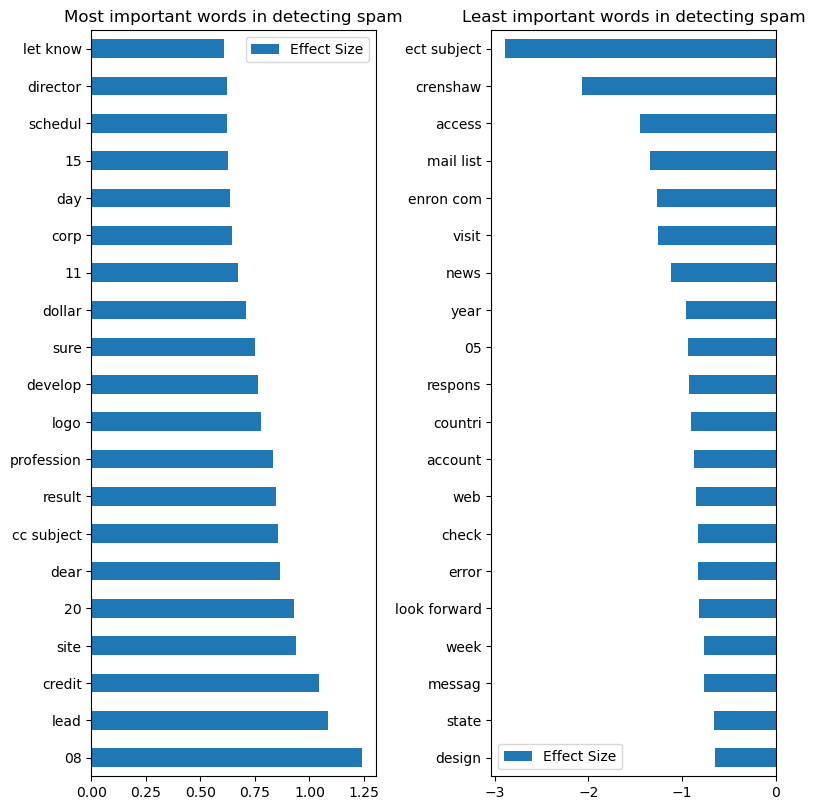

In [17]:
import matplotlib.pyplot as plt

effect_df=pd.DataFrame(logreg.coef_[0],index=X_train_cv.columns,columns=['Effect Size'])

fig, ax = plt.subplots(ncols=2,figsize=(8,8))
effect_df.sort_values(by='Effect Size',ascending=False).head(20).plot(kind='barh',ax=ax[0])
effect_df.sort_values(by='Effect Size',ascending=False).tail(20).plot(kind='barh',ax=ax[1])
fig.tight_layout()
ax[0].set_title('Most important words in detecting spam')
ax[1].set_title('Least important words in detecting spam')
plt.show()

In this example it has not made too much of a difference, but you can see how this has affected some of the words which have been used in spam detection.

## Practice

Rebuild your CountVectorizer model from earlier, this time stemming the words first. Which words come out as the most important now?

In [18]:
trip_data=pd.read_csv('tripadvisor_hotel_reviews.csv')

trip_data['target']=trip_data.Rating.apply(lambda x: 1 if x in [4,5] else 0) #create target 

trip_data.head()

,Review,Rating,target
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


In [19]:
stems=[]

for i in range(len(trip_data)):
    document=trip_data.iloc[i,0]
    document_token=nltk.word_tokenize(document)
    output= ' '.join([snowball.stem(word) for word in document_token])
    stems.append(output)
    
trip_data['stemmed']=stems

trip_data.head()

,Review,Rating,target,stemmed
0,nice hotel expensive parking got good deal sta...,4,1,nice hotel expens park got good deal stay hote...
1,ok nothing special charge diamond member hilto...,2,0,ok noth special charg diamond member hilton de...
2,nice rooms not 4* experience hotel monaco seat...,3,0,nice room not 4 * experi hotel monaco seattl g...
3,"unique, great stay, wonderful time hotel monac...",5,1,"uniqu , great stay , wonder time hotel monaco ..."
4,"great stay great stay, went seahawk game aweso...",5,1,"great stay great stay , went seahawk game awes..."


In [20]:
X_ta=trip_data[['stemmed']]
y_ta=trip_data.target

X_trainta, X_testta, y_trainta, y_testta = train_test_split(X_ta, y_ta, stratify=y_ta, train_size=0.8)

In [22]:
cvta=CountVectorizer(
    stop_words='english',
    max_df=0.9, 
    min_df=0.05,
    ngram_range=(1,2), 
    lowercase=True)

X_train_cvta=cvta.fit_transform(X_trainta.stemmed)
X_test_cvta=cvta.transform(X_testta.stemmed)
                        
X_train_dfta=pd.DataFrame( 
    X_train_cvta.toarray(), 
    columns=cvta.vocabulary_) 

X_test_dfta=pd.DataFrame( 
    X_test_cvta.toarray(), 
    columns=cvta.vocabulary_) 

In [23]:
logregta=LogisticRegression()
logregta.fit(X_train_dfta,y_trainta)

LogisticRegression()

In [24]:
print('Train score: '+ str(logregta.score(X_train_dfta,y_trainta)))
print('Test score: '+ str(logregta.score(X_test_dfta,y_testta)))
print('Baseline: '+str(trip_data.target.value_counts(normalize=True).max()))

Train score: 0.8792093704245973
Test score: 0.8653330080507441
Baseline: 0.7365672734371187


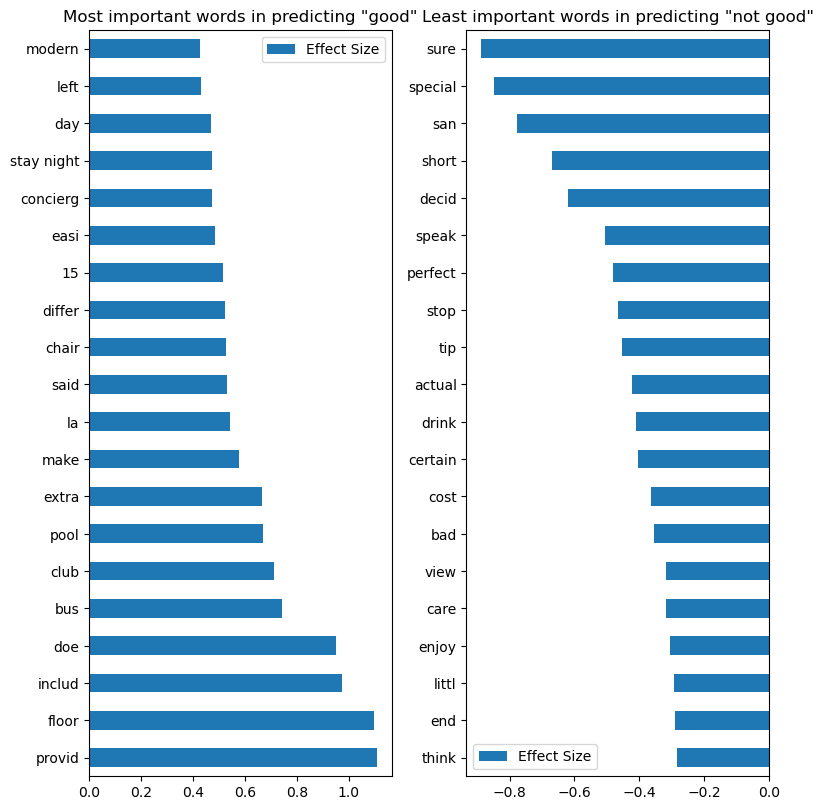

In [25]:
effect_df=pd.DataFrame(logregta.coef_[0],index=X_train_dfta.columns,columns=['Effect Size'])

fig, ax = plt.subplots(ncols=2,figsize=(8,8))
effect_df.sort_values(by='Effect Size',ascending=False).head(20).plot(kind='barh',ax=ax[0])
effect_df.sort_values(by='Effect Size',ascending=False).tail(20).plot(kind='barh',ax=ax[1])
fig.tight_layout()
ax[0].set_title('Most important words in predicting "good"')
ax[1].set_title('Least important words in predicting "not good"')
plt.show()

## 2) Lemmatization

Stemming is simply chopping off the ends of words- its fast bit not sophisticated. Lemmatization on the other hand is a slower process where it checks the meaning (lemma) of each word. This process will only work if the dictionary the library is built on contains the words it is referencing.

Compared to stemming, this is a slower but mor accurate process. 

There are several lemmatizers we can use, let's first look at nltk:

In [27]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to C:\Users\Alastair
[nltk_data]     Tyson\AppData\Roaming\nltk_data...


True

In [28]:
from nltk import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemmatizer.lemmatize('chases')

'chase'

Let's see how it works when we supply a list of words:

In [29]:
words=['takes','hires','finding','are']

for word in words:
    print(lemmatizer.lemmatize(word))

take
hire
finding
are


Something to be aware of is the Lemmatization works differently depending on which part of speech is working on (i.e. nouns, adjectives, verbs). By default it is set to noun, but if you want to change the part of speech we just add it in as an argument:

In [30]:
words=['takes','hires','finding','are']

for word in words:
    print(lemmatizer.lemmatize(word, pos='v')) #verb

take
hire
find
be


In [31]:
words=['takes','hires','finding','are']

for word in words:
    print(lemmatizer.lemmatize(word, pos='a')) #adjective

takes
hires
finding
are


In [32]:
words=['takes','hires','finding','are']

for word in words:
    print(lemmatizer.lemmatize(word, pos='r')) #adverb

takes
hires
finding
are


The problem you might spot is when passing through a list of words from a document, they will all come from a different part of speech. What we need to do is for each word detect what part of speech it is from, before it is passed through the lammatizer. That's where the `pos_tag()` function from nltk comes in.

In [33]:
nltk.pos_tag(['friendly'])

[('friendly', 'RB')]

RB means it is an adverb in computer speak, if you want a full list of what a word can be, you can check <a href='https://www.ibm.com/docs/en/watson-explorer/10.0.0?topic=analytics-part-speech-tag-sets'>here</a>.

Given `pos_tag` returns what type of word it is, we can then write some code that will take in a word, decide its part of speech and then apply the appropriate lemmatizer:

In [34]:
from nltk.corpus import wordnet # this library contains info on different parts of speech


def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper() # returns the first letter from the pos tag
    tag_dict = {"J": wordnet.ADJ, # refers to the code the lemmatizer will require
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN) # returns the appropriate code

get_wordnet_pos('friendly')

'r'

Let's try it with a sentence.

In [35]:
sentence="The strongest competitor was also the quickest at building Lego models "

print([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(sentence)])

['The', 'strong', 'competitor', 'be', 'also', 'the', 'quick', 'at', 'building', 'Lego', 'model']


You can see how some words have been stemmed ('beginning' -> 'begin') and others have been reduced to their lemma ('was' -> 'be').

To break down the code, the sentence is being broken down into individual words by `nltk.word_tokenize()` and then each individual word is being passed through the lemmatizer as well as the part of speech code, which is referenced from the earlier built function. All of this is collected into a list.

### Practice

Replace the sentance above and see how it is lemmatized.

If you'd like you can rebuild either of the models you have seen in this Activate, but be warned, Lemmatization can take a long time...

### Example

(Note: the below code can take a while to run)

In [36]:
lems=[]

for i in range(len(spam)):
    document=spam.iloc[i,0]
    document_token=nltk.word_tokenize(document)
    output= ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in nltk.word_tokenize(document)])
    lems.append(output)
    
spam['lemmatized']=lems

spam.head()

,text,spam,stemmed,lemmatized
0,naturally irresistible your corporate identity...,1.0,natur irresist your corpor ident lt is realli ...,naturally irresistible your corporate identity...
1,the stock trading gunslinger fanny is merrill...,1.0,the stock trade gunsling fanni is merril but m...,the stock trading gunslinger fanny be merrill ...
2,unbelievable new homes made easy im wanting t...,1.0,unbeliev new home made easi im want to show yo...,unbelievable new home make easy im want to sho...
3,4 color printing special request additional i...,1.0,4 color print special request addit inform now...,4 color printing special request additional in...
4,"do not have money , get software cds from here...",1.0,"do not have money , get softwar cds from here ...","do not have money , get software cd from here ..."


In [38]:
X=spam[['lemmatized']]
y=spam.spam

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

cv=CountVectorizer(
    stop_words='english',
    max_df=0.9, 
    min_df=0.05,
    ngram_range=(1,2), 
    lowercase=True)

X_train_cv=cv.fit_transform(X_train.lemmatized)
X_test_cv=cv.transform(X_test.lemmatized)
                        
X_train_cv=pd.DataFrame( 
    X_train_cv.toarray(), 
    columns=cv.vocabulary_) 

X_test_cv=pd.DataFrame( 
    X_test_cv.toarray(), 
    columns=cv.vocabulary_) 

In [39]:
logreg=LogisticRegression()
logreg.fit(X_train_cv,y_train)

LogisticRegression()

In [40]:
print('Train score: '+ str(logreg.score(X_train_cv,y_train)))
print('Test score: '+ str(logreg.score(X_test_cv,y_test)))
print('Baseline: '+str(spam.spam.value_counts(normalize=True).max()))

Train score: 0.99265605875153
Test score: 0.9828850855745721
Baseline: 0.6696035242290749


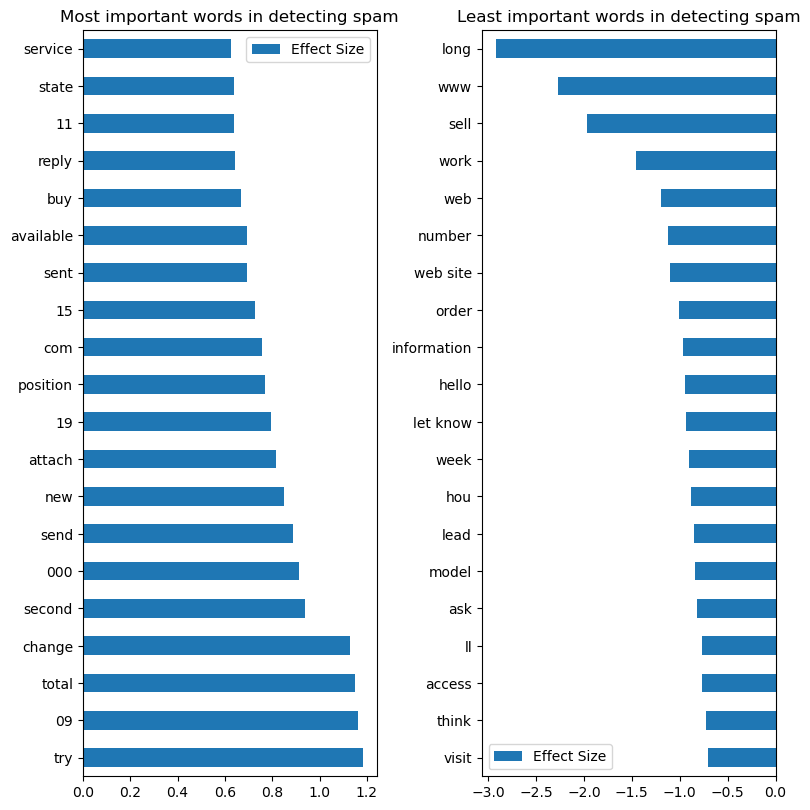

In [41]:
effect_df=pd.DataFrame(logreg.coef_[0],index=logreg.feature_names_in_,columns=['Effect Size'])

fig, ax = plt.subplots(ncols=2,figsize=(8,8))
effect_df.sort_values(by='Effect Size',ascending=False).head(20).plot(kind='barh',ax=ax[0])
effect_df.sort_values(by='Effect Size',ascending=False).tail(20).plot(kind='barh',ax=ax[1])
fig.tight_layout()
ax[0].set_title('Most important words in detecting spam')
ax[1].set_title('Least important words in detecting spam')
plt.show()

## Other libraries

NLTK is not the only library that can do NLP, more recently spaCY and TextBlob have come to the fore. 

spaCY is the newest, and one of the most powerful NLP libraries out there. It also has a very simple lemmatization process:

In [43]:
import spacy

nlp = spacy.load("en_core_web_sm")

doc = nlp(sentence)

" ".join([token.lemma_ for token in doc])

'the strong competitor be also the quick at build Lego model'

(if you are struggling to install spaCY, check back to the start of this workbook, there is an extra module you may need to install)

There is also TextBlob which again has a simple process for Lemmatizing words:

In [44]:
from textblob import TextBlob, Word

lems= TextBlob(sentence)

" ". join([word.lemmatize() for word in lems.words])

'The strongest competitor wa also the quickest at building Lego model'

TextBlob has the same issue as NLTK in that it is set up to lemmatize nouns, if you want it to react to each word part of speech we need to write a new function:

In [45]:
def lemmatize_with_pos(sentence):
    lems = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(word, tag_dict.get(pos[0], 'n')) for word, pos in lems.tags]    
    lemmatized_list = [word.lemmatize(tag) for word, tag in words_and_tags]
    return " ".join(lemmatized_list)

In [46]:
lemmatize_with_pos(sentence)

'The strong competitor be also the quick at building Lego model'

ALl three libraries will lemmatize just as well as each other, it's a matter of preference which one you choose.

## Named Entity Recognition (NER)

Let's say you have a large body of text and you need to find within it some key information, like someone's name. Or you want to build a search engine for the all the documents you have stored on your computer. This is where NER comes in, it can take any body of text and returns for each word what type of word it is. 

The choices are:

<table>
    <tr>
        <th> Type </th>
        <th> Description </th>
    </tr>
    <tr>
        <td> PERSON </td>
        <td> Someone's name </td>
    </tr>
    <tr>
        <td> NORP </td>
        <td> Nationality, religion or political group </td>
    </tr>
    <tr>
        <td> FACILITY </td>
        <td> Building, road, etc </td>
    </tr>
    <tr>
        <td> ORG </td>
        <td> Organization name </td>
    </tr>
    <tr>
        <td> GPE </td>
        <td> Country name, city, state, etc </td>
    </tr>
    <tr>
        <td> LOC </td>
        <td> Other geographical locations like mountains, oceans, etc </td>
    </tr>
    <tr>
        <td> PRODUCT </td>
        <td> Food, drink, car, etc </td>
    </tr>
    <tr>
        <td> EVENT </td>
        <td> Significant event (e.g. battle of Hastings) </td>
    </tr>
    <tr>
        <td> WORK_OF_ART </td>
        <td> Books, films, songs, etc </td>
    </tr>
    <tr>
        <td> LAW </td>
        <td> Bills, laws, etc </td>
    </tr>
    <tr>
        <td> LANGUAGE </td>
        <td> Named language </td>
    </tr>
    <tr>
        <td> DATE </td>
        <td> Dates or periods of time </td>
    </tr>
    <tr>
        <td> TIME </td>
        <td> Times smaller than a day </td>
    </tr>
    <tr>
        <td> PERCENT </td>
        <td> Percentage </td>
    </tr>
    <tr>
        <td> MONEY </td>
        <td> Units of money </td>
    </tr>
    <tr>
        <td> QUANTITY </td>
        <td> Measurements </td>
    </tr>
    <tr>
        <td> ORDINAL </td>
        <td> Rankings </td>
    </tr>
    <tr>
        <td> CARDINAL </td>
        <td> Any other type of number </td>
    </tr>
</table>
    
To use them we need to use the spaCY library.
    
This is a library trained on English websites to recognise significant elemts within our text. 

Let's try it with one of our spam emails:

In [47]:
nlp = spacy.load("en_core_web_sm")

spam_email=spam.iloc[10,0] # collect a spam email

ner=nlp(spam_email)

print([(doc.text, doc.label_) for doc in ner.ents])

[('las vegas', 'GPE'), ('las vegas', 'GPE'), ('60', 'CARDINAL'), ('the las vegas strip', 'FAC'), ('the next 3 - 4 years', 'DATE'), ('30', 'DATE'), ('first', 'ORDINAL'), ('las vegas', 'GPE'), ('cosmopolitan', 'NORP'), ('mgm', 'ORG'), ('comif', 'PERSON')]


## Practice

Build a tool that does the following:

<ul>
    <li> Takes a trip adviser review as an input </li>
    <li> Passes the review through an NER function </li>
    <li> Returns a dataframe that shows for each entity, what it is </li>
</ul>

In [48]:
state=False
while state==False:
    try:
        review_no=int(input('Select a review number: '))
        review_email=trip_data.iloc[review_no,0]
        state=True
    except:
        print('Choose number between 0 and ' + str(len(trip_data)))
        
ner=nlp(review_email)

entities=[]
labels=[]
for doc in ner.ents:
    entities.append(doc.text)
    labels.append(doc.label_)
    
df=pd.DataFrame({'Entity':entities,'Label':labels})
df

Select a review number: 4


,Entity,Label
0,english,LANGUAGE
1,arabic,NORP
2,second,ORDINAL
3,2 miles,QUANTITY
4,7,CARDINAL
5,evening,TIME
6,bernard time,PERSON
7,spanish,NORP


## Sentiment Analysis

So far we have seen how we can use NLP to turn words into analyzable features, break them down to their roots and identify what category they are in- but this still doesn't come close to how complicated human language is. 

When we read or listen we don't just take the words in isolation, we string them together to get meaning. One of the processes we follow naturally is to understand the sentiment- the emotion behind the words. Is the speaker happy or sad? Angry or passive? We can tell when reading a text, but a computer cannot.

This is where sentiment analysis comes in. This process takes a piece of text and determines whether it is positive, negative or neutral. The techniques we will look at in this workbook will be simple (and therefore will be limited), but the field of sentiment analysis is ever developing.

Applications of this include building tools to check the tone of text (e.g. Grammarly), and to understand the emotion or intention of text.

## No, I am your analyzer

For simple cases of sentiment analysis we can use a library called <b>VADER</b> (Valence Aware Dictionary for Sentiment Reasoning) that comes as part of NLTK. The process is simple, the library is build upon a dictionary where words have already been assigned a score based on how positive (called <b>polarity</b>) they are. The function will then cross-reference each word in a document against this dictionary and average out the scores. The closer then score is to 1, the more positive it is.

Let's do some examples:

In [49]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid=SentimentIntensityAnalyzer() #set up analyzer

sid.polarity_scores('happy') #enter whatever word you want here

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5719}

Ths function has returned the polarity (how positive) score of the word. The first three outputs tell us how negative, neutral and positive the word is (each between 0 and 1). The compound is the polarity score, it ranges from -1 to 1 with scores greater than 0.05 positive and scores less than -0.05 negative. Anything in between is neutral. 

We can also run this function on whole sentences (or documents):

In [50]:
print(sentence)

sid.polarity_scores(sentence)

The strongest competitor was also the quickest at building Lego models 


{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

The first three scores are now averages of all the words included in the document, with the compound still being the overall polarity.

Let's check for a spam email as well:

In [51]:
spam_email=spam.iloc[3,0] # choose a spam message
print(spam_email)

sid.polarity_scores(spam_email)

4 color printing special  request additional information now ! click here  click here for a printable version of our order form ( pdf format )  phone : ( 626 ) 338 - 8090 fax : ( 626 ) 338 - 8102 e - mail : ramsey @ goldengraphix . com  request additional information now ! click here  click here for a printable version of our order form ( pdf format )  golden graphix & printing 5110 azusa canyon rd . irwindale , ca 91706 this e - mail message is an advertisement and / or solicitation . 


{'neg': 0.0, 'neu': 0.953, 'pos': 0.047, 'compound': 0.508}

This a very simple analyzer, but it does have limitations. Check the sentence below, how positive would you sat it is?

In [52]:
new_sentence="The ham and cheese sandwich at Gordon's Happy Kitchen was not good"

Run the sentiment analyzer below to check the score:

In [53]:
sid.polarity_scores(new_sentence) 

{'neg': 0.149, 'neu': 0.621, 'pos': 0.23, 'compound': 0.3169}

The analyzer is detecting the word "not" as negative, but has also seen "good" and "Happy" (proper noun) which has tipped the polarity score into positive. More robust sentiment analyzers might be able to handle this, but VADER cannot. We could fix this by combining the analyzer with a Named Entity Recognition tool to remove any proper nouns that might confuse it:

In [54]:
def polarity_score_cleaned(sentence):

    ner=nlp(sentence)
    
    # Create dictionary of entities and their labels within the sentence
    ent_dic={}
    for ent in ner.ents:
        ent_dic[ent]=ent.label_

    # create list of words which are proper nouns   
    remove_words=[]
    for key in ent_dic.keys():
        if ent_dic[key] in ['ORG','PERSON','GPE','NORP','FACILITY','LOC','PRODUCT','EVENT','WORK_OF_ART','LAW','LANGUAGE']:
            for word in key:
                remove_words.append(word)
    
    # Collect the remaining words which are not proper nouns
    output=''
    for wd in ner:
        if wd not in remove_words:
            output+=str(wd) + ' '
    
    print(output)
    return sid.polarity_scores(output)

In [55]:
polarity_score_cleaned(new_sentence)

The ham and cheese sandwich at Gordon 's Happy Kitchen was not good 


{'neg': 0.141, 'neu': 0.643, 'pos': 0.216, 'compound': 0.3169}

This by no means is the best solution (as it could remove words which are not proper nouns), but it shows how we can combine different NLP functions together to create more powerful tools.

Another application for sentiment analysis is using the output for classification models. Going back to our spam filter, let's hypothesise that spam emails are more positive than non spam emails. We can build a spam filter that classifies emails based on their polarity score:

In [56]:
sentiments=[]

# Loop through the dataframe and calculate the polarity for each spam message
for i in range(len(spam)):
    polarity=sid.polarity_scores(spam.iloc[i,0])
    sentiments.append(polarity['compound']) # we only need the compound score as it is the overall polarity
    
spam['polarity']=sentiments
spam[['text','polarity','spam']]

,text,polarity,spam
0,naturally irresistible your corporate identity...,0.9885,1.0
1,the stock trading gunslinger fanny is merrill...,0.9568,1.0
2,unbelievable new homes made easy im wanting t...,0.9169,1.0
3,4 color printing special request additional i...,0.5080,1.0
4,"do not have money , get software cds from here...",0.8122,1.0
...,...,...,...
2038,the installation of the equipment you ordered ...,-0.3400,0.0
2039,all about current and near future gas / power ...,0.8176,0.0
2040,maureen ' s expenses it appears that administ...,0.2500,0.0
2041,interview - numerical methods & finance dear ...,0.9918,0.0


In [57]:
X=spam[['polarity']]
y=spam.spam

X_trainp, X_testp, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8)

logregp=LogisticRegression()
logregp.fit(X_trainp,y_train)

LogisticRegression()

In [58]:
print('Train score: '+ str(logregp.score(X_trainp,y_train)))
print('Test score: '+ str(logregp.score(X_testp,y_test)))
print('Baseline: '+str(spam.spam.value_counts(normalize=True).max()))

Train score: 0.6695226438188494
Test score: 0.6699266503667481
Baseline: 0.6696035242290749


For spam emails it appears that using the polarity as a predictor is no better than guessing, so for this tool we should just stick with our Bag of Words approach. However, for Trip Advisor reviews this may be an effective approach...

## Practice

Build a model that predicts if a rating will be 'good' based on the polarity of the review.

In [59]:
sentiments=[]

for i in range(len(trip_data)):
    polarity=sid.polarity_scores(trip_data.iloc[i,0])
    sentiments.append(polarity['compound']) 
    
trip_data['polarity']=sentiments
trip_data[['Review','polarity','target']]

,Review,polarity,target
0,nice hotel expensive parking got good deal sta...,0.9747,1
1,ok nothing special charge diamond member hilto...,0.9787,0
2,nice rooms not 4* experience hotel monaco seat...,0.9889,0
3,"unique, great stay, wonderful time hotel monac...",0.9912,1
4,"great stay great stay, went seahawk game aweso...",0.9797,1
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",0.9834,1
20487,great location price view hotel great quick pl...,0.9753,1
20488,"ok just looks nice modern outside, desk staff ...",0.2629,0
20489,hotel theft ruined vacation hotel opened sept ...,0.9867,0


In [60]:
X_pt=trip_data[['polarity']]
y_pt=trip_data.target

X_trainpt, X_testpt, y_trainpt, y_testpt = train_test_split(X_pt, y_pt, stratify=y_pt, train_size=0.8)

logregpt=LogisticRegression()
logregpt.fit(X_trainpt,y_trainpt)

LogisticRegression()

In [61]:
print('Train score: '+ str(logregpt.score(X_trainpt,y_trainpt)))
print('Test score: '+ str(logregpt.score(X_testpt,y_testpt)))
print('Baseline: '+str(trip_data.target.value_counts(normalize=True).max()))

Train score: 0.8274158125915081
Test score: 0.8202000487923884
Baseline: 0.7365672734371187


### TextBlob

TextBlob also contains a sentiment analyzer that returns the polarity score (between -1 and 1) and also a subjectivity score (between 0 and 1), where 0 is very objective and 1 is very subjective. This allows us to understand both the tone of a piece of text and its intention:

In [62]:
print(new_sentence)

reviewed=TextBlob(new_sentence)

print(reviewed.sentiment)

The ham and cheese sandwich at Gordon's Happy Kitchen was not good
Sentiment(polarity=0.22500000000000003, subjectivity=0.8)


Again, this has been confused by the 'good' and 'Happy'. However, we can see that this review is someone's opinon and the subjectivity score has detected this.

### Practice

Try running some other sentences through TextBlob's sentiment analyzer to see their subjectivity score:

## Other useful features from TextBlob

TextBlob also contains some other powerful features you may what to investigate:

### Spell check 

NLP techniques are sensitive to spelling errors, with each variation being seen as its own entity. TextBlob's spell checker will tell you if the word is correct or not, allowing you to fix (or even replace) errors:

In [63]:
from textblob import Word

word='speling'

Word(word).spellcheck() # returns what it thinks is the correct spelling (and how confident it is)

[('spelling', 1.0)]

If you want to replace spelling errors entirely, you can just use `.correct()`:

In [64]:
error='How good is my speling?'

TextBlob(error).correct()

TextBlob("Now good is my spelling?")

### Word counts

This feature simply allows you to count up how many times a word or phrase appears in a document:

In [65]:
bee_movie=pd.read_csv('bee_script.csv')
bee_movie.head()

script=''
for i in range(len(bee_movie)):
    script+=bee_movie.iloc[i,1]+' '

In [66]:
script_blob=TextBlob(script)

script_blob.word_counts['bee']

97

### Definitions

TextBlob also allows you to find the defintion of a word, this can be useful if you are building a web scraping tool and want to understand the meaning of some words you are pulling:

In [67]:
from textblob.wordnet import VERB

word=Word('squirrel')

word.definitions

['a kind of arboreal rodent having a long bushy tail', 'the fur of a squirrel']

## Word Clouds

The final NLP process we are going to look at is Word Clouds, visualizations that show the frequency of keywords within a document. The more frequent a word is, the larger and bolder it will appear. 

In [68]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [69]:
wordcloud = WordCloud().generate(script) #generate wordcloud using a text

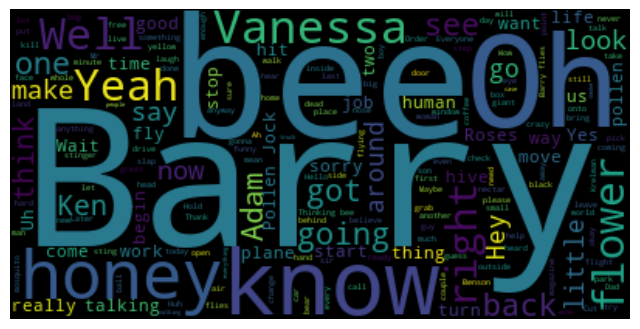

In [70]:
fig, ax =plt.subplots(figsize=(8,8))

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()

No we have our word cloud, we can start to format it.

Options include:

<ul>
    <li><b>max_font_size</b>- The maximum font a word should be</li>
    <li><b>min_font_size</b>- The minimum font a word should be</li>
    <li><b>maxwords</b>- How many words should be included</li>
    <li><b>background_color</b>- The background color</li>
    <li><b>stopwords</b>- A dictionary of words that should not be included</li>
    <li><b>mask</b>- If we want to set a shape to the wordcloud</li>
</ul>

Let's see how these look:

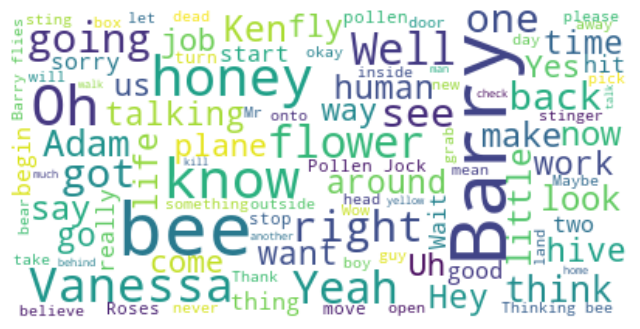

In [71]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(script)

fig, ax =plt.subplots(figsize=(8,8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()

Like before, there are common words in the English language that will overwhelm our visualization. wordcloud by default removes many of them, but there may be context specific ones which we may want to remove.

In [72]:
stopwords = set(STOPWORDS) # call list of stopwords
stopwords.update(["oh",'Hey']) #add words to the list

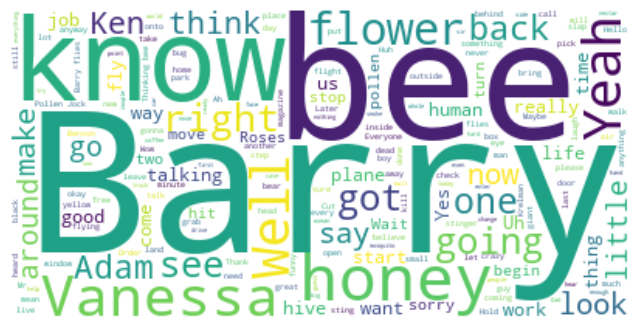

In [73]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(script)

fig, ax =plt.subplots(figsize=(8,8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()

For the final trick, let's shape the wordcloud into a bee!

To do this we need a bee png file:

<img src='bee.png'>


The first step though is to load the image into a numpy array:

In [74]:
import numpy as np
from PIL import Image

bee_mask = np.array(Image.open("bee.png"))
bee_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

This png includes a lot of greyspace, which we don't want in our image. The following code will transform the array so it only includes the bee part (it will change everything else to pure white, so won't show up).

If you are building a wordcloud with an image you want to include all of, don't include the next few blocks.

In [75]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [76]:
transformed_bee_mask = np.ndarray((bee_mask.shape[0],bee_mask.shape[1]), np.int32)

for i in range(len(bee_mask)):
    transformed_bee_mask[i] = list(map(transform_format, bee_mask[i]))
    
transformed_bee_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

Now we can pass this into our wordcloud and it will make it in the shape off a bee!

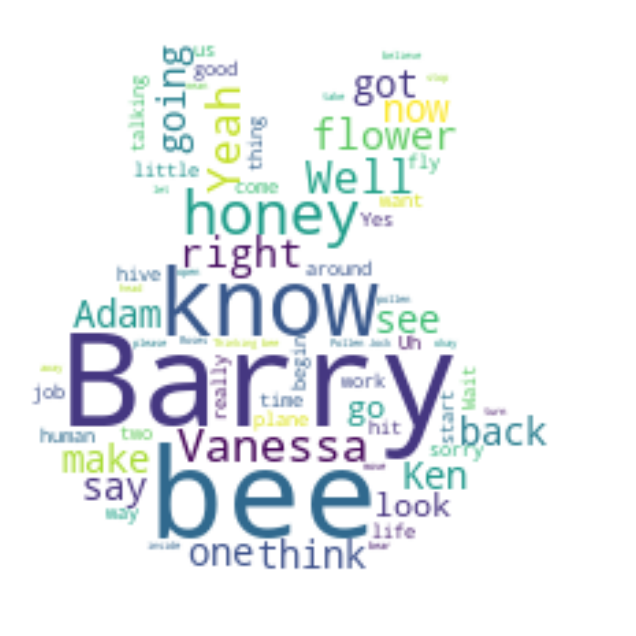

In [77]:
# If you haven't transformed your image, set mask=original array

wordcloud = WordCloud(stopwords=stopwords, background_color="white",mask=transformed_bee_mask,mode='RGB').generate(script)

fig, ax =plt.subplots(figsize=(8,8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.show()

How about giving it the correct colors as well? 

We can add a function which applies the colors in the image, but we need to transform it first as the original has too much greyscale:

In [78]:
bee_mask_color = np.array(Image.open("bee.png").convert('RGB'))

Now we have an array showing where the colors should be, we can now rebuild the wordcloud:

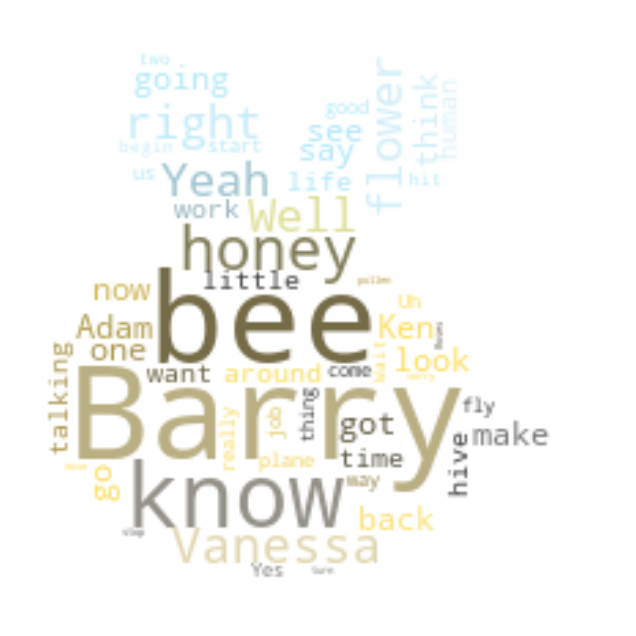

In [79]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white",mask=transformed_bee_mask,mode='RGB').generate(script)

fig, ax =plt.subplots(figsize=(8,8))
image_colors = ImageColorGenerator(bee_mask_color) # extracts the colors from the image
ax.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
ax.axis("off")
plt.show()

In [80]:
plt.savefig("bee_keywords.png", format="png") # This code will save your image if you want to share it

<Figure size 640x480 with 0 Axes>

## Practice

Make a wordcloud from the 5 star trip advisor reviews. [Stretch] Build the wordcloud in the shape of the Colosseum.

In [81]:
five_star=trip_data[trip_data.Rating==5]

text=''

for i in range(len(five_star)):
    text+= five_star.iloc[i,0] + ' '

In [82]:
col_mask = np.array(Image.open("colosseum.png"))

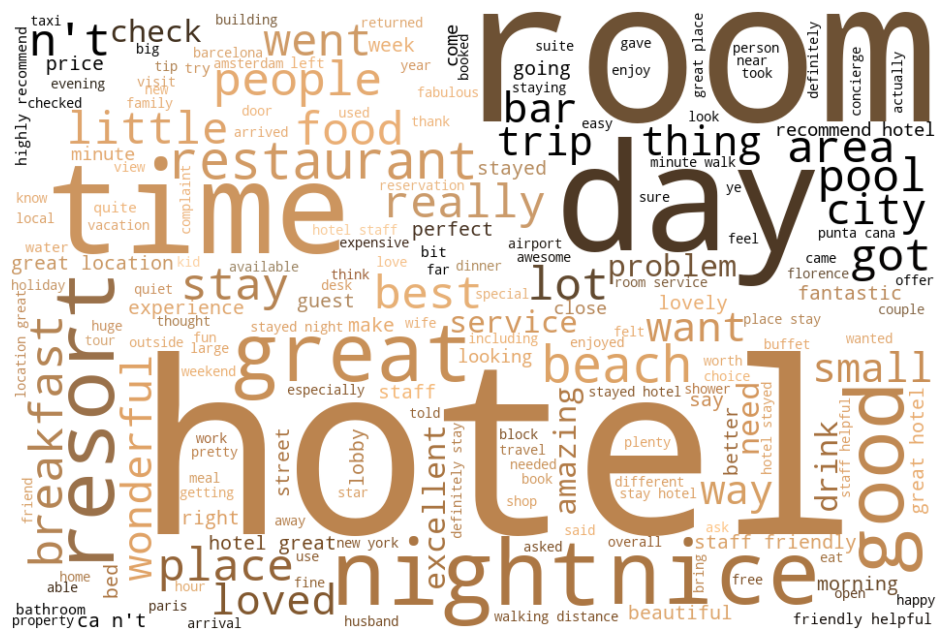

In [83]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white",mask=col_mask,mode='RGB').generate(text)

fig, ax =plt.subplots(figsize=(12,12))
image_colors = ImageColorGenerator(col_mask) # extracts the colors from the image
ax.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
ax.axis("off")
plt.show()